In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

In [2]:
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [3]:
tms_acutal_dir = "../../data/actual/TMS_Actual.csv"
flow_acutal_dir = "../../data/actual/FLOW_Actual.csv"
aws368_dir = "../../data/actual/AWS_368.csv"
aws541_dir = "../../data/actual/AWS_541.csv"
aws569_dir = "../../data/actual/AWS_569.csv"

In [4]:
tms = pd.read_csv(tms_acutal_dir)
flow = pd.read_csv(flow_acutal_dir)
aws368 = pd.read_csv(aws368_dir)
aws541 = pd.read_csv(aws541_dir)
aws569 = pd.read_csv(aws569_dir)

In [5]:
flow = flow.drop(columns=['data_save_dt'])
aws368 = aws368.drop(columns=['YYMMDDHHMI','STN'])
aws541 = aws541.drop(columns=['YYMMDDHHMI','STN'])
aws569 = aws569.drop(columns=['YYMMDDHHMI','STN'])

In [6]:
tms['SYS_TIME'] = pd.to_datetime(tms['SYS_TIME'])
flow['SYS_TIME'] = pd.to_datetime(flow['SYS_TIME'])
aws368['datetime'] = pd.to_datetime(aws368['datetime'])
aws541['datetime'] = pd.to_datetime(aws541['datetime'])
aws569['datetime'] = pd.to_datetime(aws569['datetime'])

### 단순 선형 보간 + join

In [73]:
# ⚠️ 중요: 미래값(look-ahead)을 쓰지 않기 위해 여기서는 interpolate를 하지 않는다.
# 정렬만 수행하고, 결측치 보간/대체는 아래 process_dataframe()에서 '과거값만' 사용해서 처리한다.

tms = tms.sort_values('SYS_TIME').drop_duplicates(subset='SYS_TIME', keep='first')
flow = flow.sort_values('SYS_TIME').drop_duplicates(subset='SYS_TIME', keep='first')
aws368 = aws368.sort_values('datetime').drop_duplicates(subset='datetime', keep='first')
aws541 = aws541.sort_values('datetime').drop_duplicates(subset='datetime', keep='first')
aws569 = aws569.sort_values('datetime').drop_duplicates(subset='datetime', keep='first')


In [57]:
tms.info()

<class 'pandas.DataFrame'>
RangeIndex: 514551 entries, 0 to 514550
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   SYS_TIME  514551 non-null  datetime64[us]
 1   TOC_VU    426520 non-null  float64       
 2   PH_VU     426520 non-null  float64       
 3   SS_VU     426520 non-null  float64       
 4   FLUX_VU   426525 non-null  float64       
 5   TN_VU     426524 non-null  float64       
 6   TP_VU     426520 non-null  float64       
dtypes: datetime64[us](1), float64(6)
memory usage: 27.5 MB


In [58]:
# 컬럼명 변경
aws368 = aws368.add_suffix('_368')
aws541 = aws541.add_suffix('_541')
aws569 = aws569.add_suffix('_569')

# join
flow_df = flow.join([aws368, aws541, aws569], how='left')
tms_df = tms.join([aws368, aws541, aws569], how='left')

In [59]:
# 특정 패턴 포함 컬럼 삭제
cols_to_drop = [col for col in flow_df.columns if col in ['data_save_dt', 'YYMMDDHHMI_368', 'YYMMDDHHMI_541', 'YYMMDDHHMI_569', 'STN_368', 'STN_541', 'STN_569']]
flow_df = flow_df.drop(columns=cols_to_drop)

# 특정 패턴 포함 컬럼 삭제
cols_to_drop = [col for col in tms_df.columns if col in ['data_save_dt', 'YYMMDDHHMI_368', 'YYMMDDHHMI_541', 'YYMMDDHHMI_569', 'STN_368', 'STN_541', 'STN_569']]
tms_df = tms_df.drop(columns=cols_to_drop)

In [60]:
flow_df

,flow_TankA,flow_TankB,level_TankA,level_TankB,SYS_TIME,TA_368,RN_15m_368,RN_60m_368,RN_12H_368,RN_DAY_368,...,TD_541,datetime_541,TA_569,RN_15m_569,RN_60m_569,RN_12H_569,RN_DAY_569,HM_569,TD_569,datetime_569
0,230.4000,230.2500,3.55225,3.54900,2025-09-02 23:53:00,28.3,0.0,0.0,0.0,0.0,...,23.9,2024-08-01 00:00:00,27.0,0.0,0.0,0.0,0.0,80.9,23.4,2024-08-01 00:00:00
1,229.9875,230.1000,3.54700,3.54575,2025-09-02 23:54:00,28.3,0.0,0.0,0.0,0.0,...,23.9,2024-08-01 00:01:00,27.0,0.0,0.0,0.0,0.0,80.7,23.4,2024-08-01 00:01:00
2,229.5000,230.0625,3.54825,3.54475,2025-09-02 23:55:00,28.2,0.0,0.0,0.0,0.0,...,23.9,2024-08-01 00:02:00,27.0,0.0,0.0,0.0,0.0,80.9,23.4,2024-08-01 00:02:00
3,229.8375,230.4750,3.54125,3.54250,2025-09-02 23:56:00,28.2,0.0,0.0,0.0,0.0,...,23.9,2024-08-01 00:03:00,27.0,0.0,0.0,0.0,0.0,80.9,23.4,2024-08-01 00:03:00
4,229.9125,230.0250,3.54050,3.54050,2025-09-02 23:57:00,28.3,0.0,0.0,0.0,0.0,...,24.0,2024-08-01 00:04:00,27.0,0.0,0.0,0.0,0.0,80.9,23.4,2024-08-01 00:04:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130727,199.8000,200.6250,2.43450,2.42275,2025-12-03 10:35:00,17.4,0.0,0.0,0.0,0.0,...,9.6,2024-10-30 18:47:00,16.4,0.0,0.0,0.0,0.0,64.2,9.6,2024-10-30 18:47:00
130728,199.0125,200.1375,2.43200,2.42350,2025-12-03 10:36:00,17.4,0.0,0.0,0.0,0.0,...,9.6,2024-10-30 18:48:00,16.4,0.0,0.0,0.0,0.0,63.9,9.6,2024-10-30 18:48:00
130729,199.5750,199.3875,2.42975,2.42650,2025-12-03 10:37:00,17.4,0.0,0.0,0.0,0.0,...,9.6,2024-10-30 18:49:00,16.4,0.0,0.0,0.0,0.0,63.9,9.6,2024-10-30 18:49:00
130730,199.6875,199.8375,2.43275,2.42650,2025-12-03 10:38:00,17.4,0.0,0.0,0.0,0.0,...,9.7,2024-10-30 18:50:00,16.4,0.0,0.0,0.0,0.0,63.7,9.5,2024-10-30 18:50:00


In [61]:
tms_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 514551 entries, 0 to 514550
Data columns (total 31 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   SYS_TIME      514551 non-null  datetime64[us]
 1   TOC_VU        426520 non-null  float64       
 2   PH_VU         426520 non-null  float64       
 3   SS_VU         426520 non-null  float64       
 4   FLUX_VU       426525 non-null  float64       
 5   TN_VU         426524 non-null  float64       
 6   TP_VU         426520 non-null  float64       
 7   TA_368        508179 non-null  float64       
 8   RN_15m_368    507906 non-null  float64       
 9   RN_60m_368    507783 non-null  float64       
 10  RN_12H_368    505314 non-null  float64       
 11  RN_DAY_368    507940 non-null  float64       
 12  HM_368        508179 non-null  float64       
 13  TD_368        508179 non-null  float64       
 14  datetime_368  514551 non-null  datetime64[us]
 15  TA_541        514521 non-nul

### forward fill 보간 + EWMA/EMA 보간 + 이상치 처리 + 처리 전후 시각화

In [7]:
def ensure_1min_interval(df, time_col=None, keep_time_col=True):
    """
    1분 간격인지 확인하고, 누락된 분이 있으면 행을 추가한다.
    추가된 행의 값은 NaN으로 유지한다.
    """

    df = df.copy()

    # 1. 시간 인덱스 만들기
    if time_col is not None:
        df[time_col] = pd.to_datetime(df[time_col])
        
        # ⚠️ 중복 제거는 인덱스 설정 전에
        if df[time_col].duplicated().any():
            n_dups = df[time_col].duplicated().sum()
            print(f"  경고: {n_dups}개의 중복 타임스탬프 발견, 첫 번째 값만 유지합니다.")
            df = df.drop_duplicates(subset=time_col, keep='first')

        if keep_time_col:
            df.index = df[time_col]
            df.index.name = time_col
        else:
            df = df.set_index(time_col)

    else:
        # time_col이 None이면 이미 DatetimeIndex라고 가정
        if not isinstance(df.index, pd.DatetimeIndex):
            raise ValueError("time_col이 None일 때는 DatetimeIndex여야 합니다.")
        
        # 인덱스 중복 제거
        if not df.index.is_unique:
            n_dups = df.index.duplicated().sum()
            print(f"  경고: {n_dups}개의 중복 인덱스 발견, 첫 번째 값만 유지합니다.")
            df = df[~df.index.duplicated(keep='first')]

    df = df.sort_index()

    # 2. 현재 간격 확인
    diffs = df.index.to_series().diff().dropna()
    is_1min = (diffs == pd.Timedelta(minutes=1)).all()

    # 3. 1분이 아니면 reindex
    if not is_1min:
        full_index = pd.date_range(
            start=df.index.min(),
            end=df.index.max(),
            freq="1min"
        )
        df = df.reindex(full_index)

        if time_col is not None and keep_time_col:
            df[time_col] = df.index

    # ⚠️ 최종 체크: reindex 후에도 중복이 있으면 제거
    if not df.index.is_unique:
        print(f"  경고: reindex 후 중복 발견, 제거합니다.")
        df = df[~df.index.duplicated(keep='first')]

    return df, is_1min


In [63]:
def detect_outliers_domain(series, col_name):
    """도메인 지식 기반 이상치 탐지 - 컬럼별 맞춤형"""
    
    outliers = pd.Series([False] * len(series), index=series.index)
    
    # TMS 수질 데이터
    if col_name == 'TOC_VU':  # 총유기탄소 (mg/L)
        outliers = (series < 0) | (series > 100)  # 일반적으로 0-50 범위
    
    elif col_name == 'PH_VU':  # pH
        outliers = (series < 0) | (series > 14)  # pH는 0-14 범위
    
    elif col_name == 'SS_VU':  # 부유물질 (mg/L)
        outliers = (series < 0) | (series > 500)  # 하수처리장 일반 범위
    
    elif col_name == 'FLUX_VU':  # 유량 (m³/day)
        outliers = (series < 0) | (series > series.quantile(0.99) * 3)
    
    elif col_name in ['TN_VU', 'TP_VU']:  # 총질소, 총인 (mg/L)
        outliers = (series < 0) | (series > 100)
    
    # FLOW 데이터
    elif col_name in ['flow_TankA', 'flow_TankB']:  # 유량
        outliers = (series < 0) | (series > series.quantile(0.99) * 3)
    
    elif col_name in ['level_TankA', 'level_TankB']:  # 수위 (m)
        outliers = (series < 0) | (series > 10)  # 일반적인 탱크 높이
    
    # AWS 기상 데이터
    elif col_name == 'TA':  # 기온 (°C)
        outliers = (series < -30) | (series > 45)  # 한국 기온 범위
    
    elif col_name in ['RN_15m', 'RN_60m', 'RN_12H', 'RN_DAY']:  # 강수량 (mm)
        outliers = (series < 0) | (series > 300)  # 일반적인 강수량 범위
    
    elif col_name == 'HM':  # 습도 (%)
        outliers = (series < 0) | (series > 100)  # 습도는 0-100%
    
    elif col_name == 'TD':  # 이슬점 온도 (°C)
        outliers = (series < -40) | (series > 35)
    
    else:
        # 기본값: 음수 또는 극단값
        outliers = (series < 0) | (series > series.quantile(0.999) * 2)
    
    return outliers

def detect_outliers(series, method='iqr', threshold=1.5, col_name=None):
    """이상치 탐지 - 개선 버전"""
    if method == 'iqr':
        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - threshold * IQR
        upper = Q3 + threshold * IQR
        return (series < lower) | (series > upper)
    
    elif method == 'zscore':
        z_scores = np.abs(zscore(series.dropna()))
        return z_scores > threshold
    
    elif method == 'domain':
        if col_name:
            return detect_outliers_domain(series, col_name)
        else:
            # 컬럼명이 없으면 기본 도메인 규칙 적용
            return (series < 0) | (series > series.quantile(0.999) * 2)


In [8]:
def visualize_multiple_columns(df_original, df_processed, columns, df_name, time_col=None, save_path=None):
    """여러 컬럼의 처리 전후를 한 그래프에 시각화"""
    
    n_cols = len(columns)
    fig, axes = plt.subplots(n_cols, 1, figsize=(16, 4 * n_cols))
    
    if n_cols == 1:
        axes = [axes]
    
    # 시간 인덱스 설정
    if time_col in df_original.columns:
        x_original = pd.to_datetime(df_original[time_col])
        x_processed = pd.to_datetime(df_processed[time_col])
    else:
        x_original = range(len(df_original))
        x_processed = range(len(df_processed))
    
    for idx, col in enumerate(columns):
        ax = axes[idx]
        
        # 원본 데이터
        ax.plot(x_original, df_original[col], label='원본', alpha=0.5, linewidth=1, color='blue')
        
        # 처리 후 데이터
        ax.plot(x_processed, df_processed[col], label='처리 후', alpha=0.5, linewidth=1, color='green')
        
        # 이상치 표시
        #outliers = detect_outliers(df_original[col], method='iqr')
        #if outliers.sum() > 0:
        #    ax.scatter(x_original[outliers], df_original[col][outliers], 
        #              color='red', label=f'이상치 ({outliers.sum()}개)', s=20, zorder=5, alpha=0.6)
        
        # 결측치 영역 표시
        missing_original = df_original[col].isnull()
        if missing_original.sum() > 0:
            ax.fill_between(x_original, ax.get_ylim()[0], ax.get_ylim()[1], 
                           where=missing_original, alpha=0.1, color='gray', 
                           label=f'원본 결측 ({missing_original.sum()}개)')
        
        ax.set_title(f'{col} - 처리 전후 비교', fontsize=12, fontweight='bold')
        ax.set_xlabel('시간')
        ax.set_ylabel(col)
        ax.legend(loc='upper right', fontsize=9)
        ax.grid(True, alpha=0.3)
        
        # 통계 정보 추가
        stats_text = (f'원본: 평균={df_original[col].mean():.2f}, 표준편차={df_original[col].std():.2f}\n'
                     f'처리 후: 평균={df_processed[col].mean():.2f}, 표준편차={df_processed[col].std():.2f}')
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
               fontsize=8, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"  시각화 저장: {save_path}")
    
    plt.show()

In [9]:
def create_summary_table(df_original, df_processed, columns, df_name):
    """처리 전후 요약 테이블 생성"""
    
    summary_data = []
    
    for col in columns:
        original_missing = df_original[col].isnull().sum()
        processed_missing = df_processed[col].isnull().sum()
        #outliers = detect_outliers(df_original[col], method='iqr').sum()
        
        summary_data.append({
            '컬럼': col,
            '원본_결측': original_missing,
            '원본_결측률(%)': f"{original_missing/len(df_original)*100:.2f}",
            #'이상치': outliers,
            #'이상치율(%)': f"{outliers/len(df_original)*100:.2f}",
            '처리후_결측': processed_missing,
            '원본_평균': f"{df_original[col].mean():.2f}",
            '처리후_평균': f"{df_processed[col].mean():.2f}",
            '원본_표준편차': f"{df_original[col].std():.2f}",
            '처리후_표준편차': f"{df_processed[col].std():.2f}"
        })
    
    summary_df = pd.DataFrame(summary_data)
    
    print(f"\n{'='*80}")
    print(f"[{df_name}] 처리 요약")
    print(f"{'='*80}")
    print(summary_df.to_string(index=False))
    
    return summary_df

In [16]:
def _causal_impute_series(
    s: pd.Series,
    *,
    ffill_limit_steps: int = 6,          # 1분 데이터 기준: 6이면 최대 6분까지만 ffill
    ema_span_steps: int = 12,            # 지수평활(EMA) span
    rolling_median_window_steps: int = 288,  # 1분 기준 288=4시간(필요시 조정)
):
    """미래값을 쓰지 않는(causal) 결측 대체.
    반환: filled, is_missing, imputed_ffill, imputed_ema, imputed_rollmed, age_steps
    - 선행 NaN(시작 구간)은 미래값을 쓸 수 없으므로 그대로 NaN으로 남을 수 있다.
    """
    s = s.copy()
    if not isinstance(s.index, pd.DatetimeIndex):
        raise ValueError("Series index must be DatetimeIndex for age computation.")

    is_missing = s.isna()

    # age: 마지막 관측 이후 경과 step(분/5분 등은 resample 주기에 따라 step 의미가 달라짐)
    last_obs_time = s.index.where(~is_missing).to_series().ffill()
    age_steps = (s.index.to_series() - last_obs_time).dt.total_seconds() / 60.0  # minutes
    # 관측치인 지점은 age=0, 선행결측(NaT)은 NaN 유지
    age_steps = age_steps.where(is_missing, 0.0)

    # 1) 제한된 ffill (과거값만)
    s_ffill = s.ffill(limit=ffill_limit_steps)
    imputed_ffill = is_missing & s_ffill.notna()

    # 2) EMA (과거 기반 smoothing)로 남은 결측 일부 대체
    # - adjust=False: online 업데이트 느낌(과거만 반영)
    # - s_ffill 기반으로 계산하므로 미래값 없음
    ema = s_ffill.ewm(span=ema_span_steps, adjust=False).mean()
    need_ema = s_ffill.isna()
    s_ema = s_ffill.copy()
    s_ema[need_ema] = ema[need_ema]
    imputed_ema = need_ema & ema.notna()

    # 3) 과거 rolling median (완전 causal)로 남은 결측 보완
    rollmed = s_ema.rolling(window=rolling_median_window_steps, min_periods=1).median()
    need_roll = s_ema.isna()
    s_final = s_ema.copy()
    s_final[need_roll] = rollmed[need_roll]
    imputed_rollmed = need_roll & rollmed.notna()

    return s_final, is_missing, imputed_ffill, imputed_ema, imputed_rollmed, age_steps


def process_dataframe(
    df,
    columns,
    df_name,
    time_col='time',
    save_dir='../../results',
    *,
    ffill_limit_steps: int = 6,
    ema_span_steps: int = 12,
    rolling_median_window_steps: int = 288,
):
    """여러 컬럼을 한 번에 처리(미래값 미사용) + 마스크 생성"""

    print(f"\n{'#'*80}")
    print(f"# [{df_name}] 데이터 처리 시작")
    print(f"{'#'*80}")

    df_original = df.copy()

    # 1) 1분 간격 reindex (누락 timestamp는 행을 추가하고 NaN 유지)
    df_processed, was_1min = ensure_1min_interval(df, time_col)
    print(f"\n시간 간격 체크: {'이미 1분 간격' if was_1min else '1분 간격으로 reindex 완료'}")
    print(f"  원본 행 수: {len(df_original)}, 처리 후 행 수: {len(df_processed)}")

    # time_col이 index로도 있고 컬럼으로도 있게 유지(기존 로직 호환)
    df_processed = df_processed.sort_index()

    # 2) 컬럼별 causal imputation + 마스크/age 추가
    for col in columns:
        print(f"\n[{col}] 처리 중...")

        # 원본 결측(마스크의 기준)은 'reindex 후' 시점이 더 실용적임
        # (즉, 원래 없던 timestamp가 추가되면 그건 결측으로 보는 게 맞음)
        s = df_processed[col]
        original_missing = s.isna().sum()
        print(f"  결측치(리인덱스 후): {original_missing}개")

        filled, is_missing, m_ffill, m_ema, m_roll, age_min = _causal_impute_series(
            s,
            ffill_limit_steps=ffill_limit_steps,
            ema_span_steps=ema_span_steps,
            rolling_median_window_steps=rolling_median_window_steps,
        )

        # 값 업데이트
        df_processed[col] = filled

        # 마스크/메타 컬럼 추가 (모델 입력용)
        # 인덱스를 맞춰서 할당 (reindex 사용)
        df_processed[f"{col}__is_missing"] = is_missing.reindex(df_processed.index, fill_value=0).astype('int8')
        df_processed[f"{col}__imputed_ffill"] = m_ffill.reindex(df_processed.index, fill_value=0).astype('int8')
        df_processed[f"{col}__imputed_ema"] = m_ema.reindex(df_processed.index, fill_value=0).astype('int8')
        df_processed[f"{col}__imputed_rollmed"] = m_roll.reindex(df_processed.index, fill_value=0).astype('int8')
        #df_processed[f"{col}__age_min"] = age_min.reindex(df_processed.index, fill_value=np.nan).astype('float32')


        final_missing = df_processed[col].isna().sum()
        print(
            f"  대체 후 결측치: {final_missing}개 | "
            f"ffill={int(m_ffill.sum())}, ema={int(m_ema.sum())}, rollmed={int(m_roll.sum())}"
        )

    # 3) 요약 테이블(원본 vs 처리후 값) — 마스크 컬럼은 제외
    summary_df = create_summary_table(df_original, df_processed, columns, df_name)

    # 4) 시각화 — 마스크 컬럼 제외(원본 컬럼만)
    print(f"\n시각화 생성 중...")
    visualize_multiple_columns(
        df_original,
        df_processed,
        columns,
        df_name,
        time_col,
        save_path=f'{save_dir}/{df_name}_before_after.png'
    )

    # 5) 요약 테이블 저장
    summary_df.to_csv(f'{save_dir}/{df_name}_summary.csv', index=False, encoding='utf-8-sig')
    print(f"  요약 테이블 저장: {save_dir}/{df_name}_summary.csv")

    return df_processed


tms_columns = ['TOC_VU', 'PH_VU', 'SS_VU', 'FLUX_VU', 'TN_VU', 'TP_VU']
flow_columns = ['flow_TankA', 'flow_TankB', 'level_TankA', 'level_TankB']
aws_columns = ['TA', 'RN_15m', 'RN_60m', 'RN_12H', 'RN_DAY', 'HM', 'TD']

# 기본 파라미터 예시(1분 기준):
# - ffill_limit_steps=6  : 최대 6분까지만 ffill
# - ema_span_steps=12    : EMA span 12분
# - rolling_median_window_steps=288 : 4시간 rolling median





In [11]:
tms_columns = ['TOC_VU', 'PH_VU', 'SS_VU', 'FLUX_VU', 'TN_VU', 'TP_VU']
flow_columns = ['flow_TankA', 'flow_TankB', 'level_TankA', 'level_TankB']
aws_columns = ['TA', 'RN_15m', 'RN_60m', 'RN_12H', 'RN_DAY', 'HM', 'TD']


################################################################################
# [TMS] 데이터 처리 시작
################################################################################

시간 간격 체크: 1분 간격으로 reindex 완료
  원본 행 수: 514551, 처리 후 행 수: 573975

[TOC_VU] 처리 중...
  결측치(리인덱스 후): 147455개
  대체 후 결측치: 0개 | ffill=5464, ema=141991, rollmed=0

[PH_VU] 처리 중...
  결측치(리인덱스 후): 147455개
  대체 후 결측치: 0개 | ffill=5464, ema=141991, rollmed=0

[SS_VU] 처리 중...
  결측치(리인덱스 후): 147455개
  대체 후 결측치: 0개 | ffill=5464, ema=141991, rollmed=0

[FLUX_VU] 처리 중...
  결측치(리인덱스 후): 147450개
  대체 후 결측치: 0개 | ffill=5465, ema=141985, rollmed=0

[TN_VU] 처리 중...
  결측치(리인덱스 후): 147451개
  대체 후 결측치: 0개 | ffill=5465, ema=141986, rollmed=0

[TP_VU] 처리 중...
  결측치(리인덱스 후): 147455개
  대체 후 결측치: 0개 | ffill=5464, ema=141991, rollmed=0

[TMS] 처리 요약
     컬럼  원본_결측 원본_결측률(%)  처리후_결측    원본_평균   처리후_평균   원본_표준편차  처리후_표준편차
 TOC_VU  88031     17.11       0     5.28     4.94     10.29      8.89
  PH_VU  88031     17.11       0     7.06     7.02

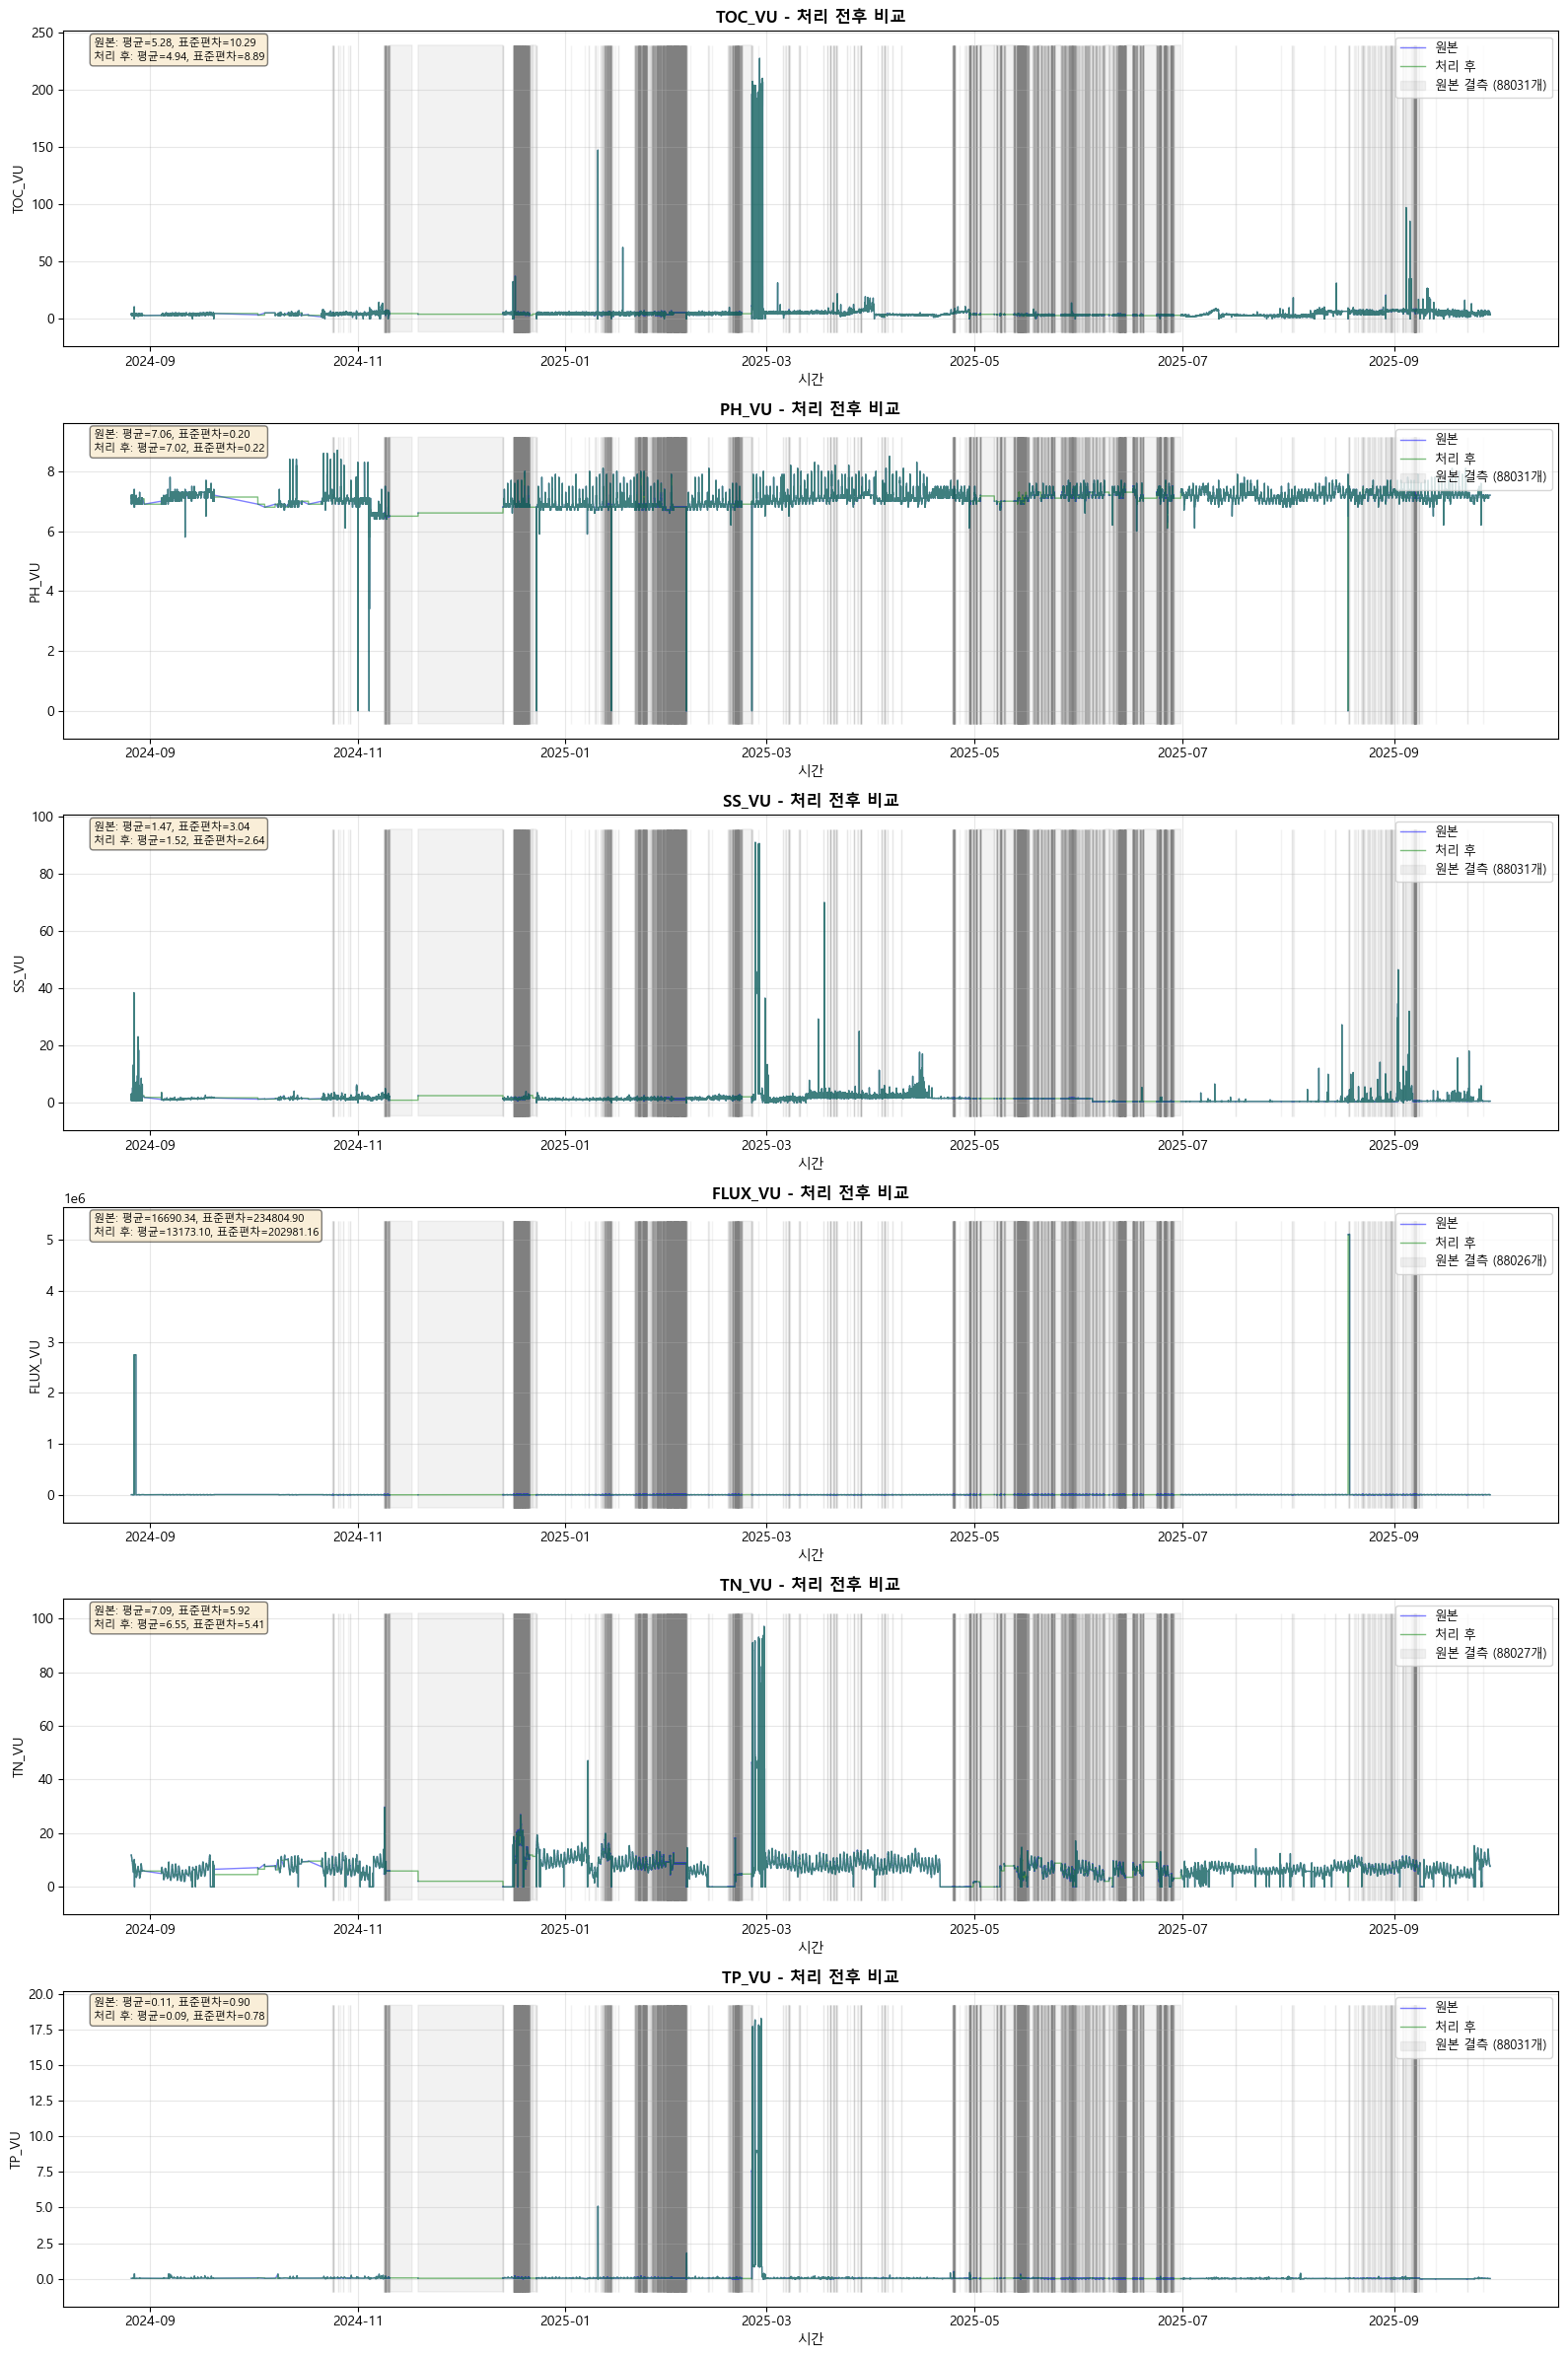

  요약 테이블 저장: ../../results/TMS_summary.csv

################################################################################
# [FLOW] 데이터 처리 시작
################################################################################

시간 간격 체크: 1분 간격으로 reindex 완료
  원본 행 수: 130732, 처리 후 행 수: 131687

[flow_TankA] 처리 중...
  결측치(리인덱스 후): 955개
  대체 후 결측치: 0개 | ffill=954, ema=1, rollmed=0

[flow_TankB] 처리 중...
  결측치(리인덱스 후): 955개
  대체 후 결측치: 0개 | ffill=954, ema=1, rollmed=0

[level_TankA] 처리 중...
  결측치(리인덱스 후): 955개
  대체 후 결측치: 0개 | ffill=954, ema=1, rollmed=0

[level_TankB] 처리 중...
  결측치(리인덱스 후): 955개
  대체 후 결측치: 0개 | ffill=954, ema=1, rollmed=0

[FLOW] 처리 요약
         컬럼  원본_결측 원본_결측률(%)  처리후_결측  원본_평균 처리후_평균 원본_표준편차 처리후_표준편차
 flow_TankA      0      0.00       0 182.56 182.55   47.49    47.51
 flow_TankB      0      0.00       0 197.11 197.10   53.95    53.96
level_TankA      0      0.00       0   2.48   2.48    0.64     0.64
level_TankB      0      0.00       0   2.48   2.48    0.64     0.64

시각화 생

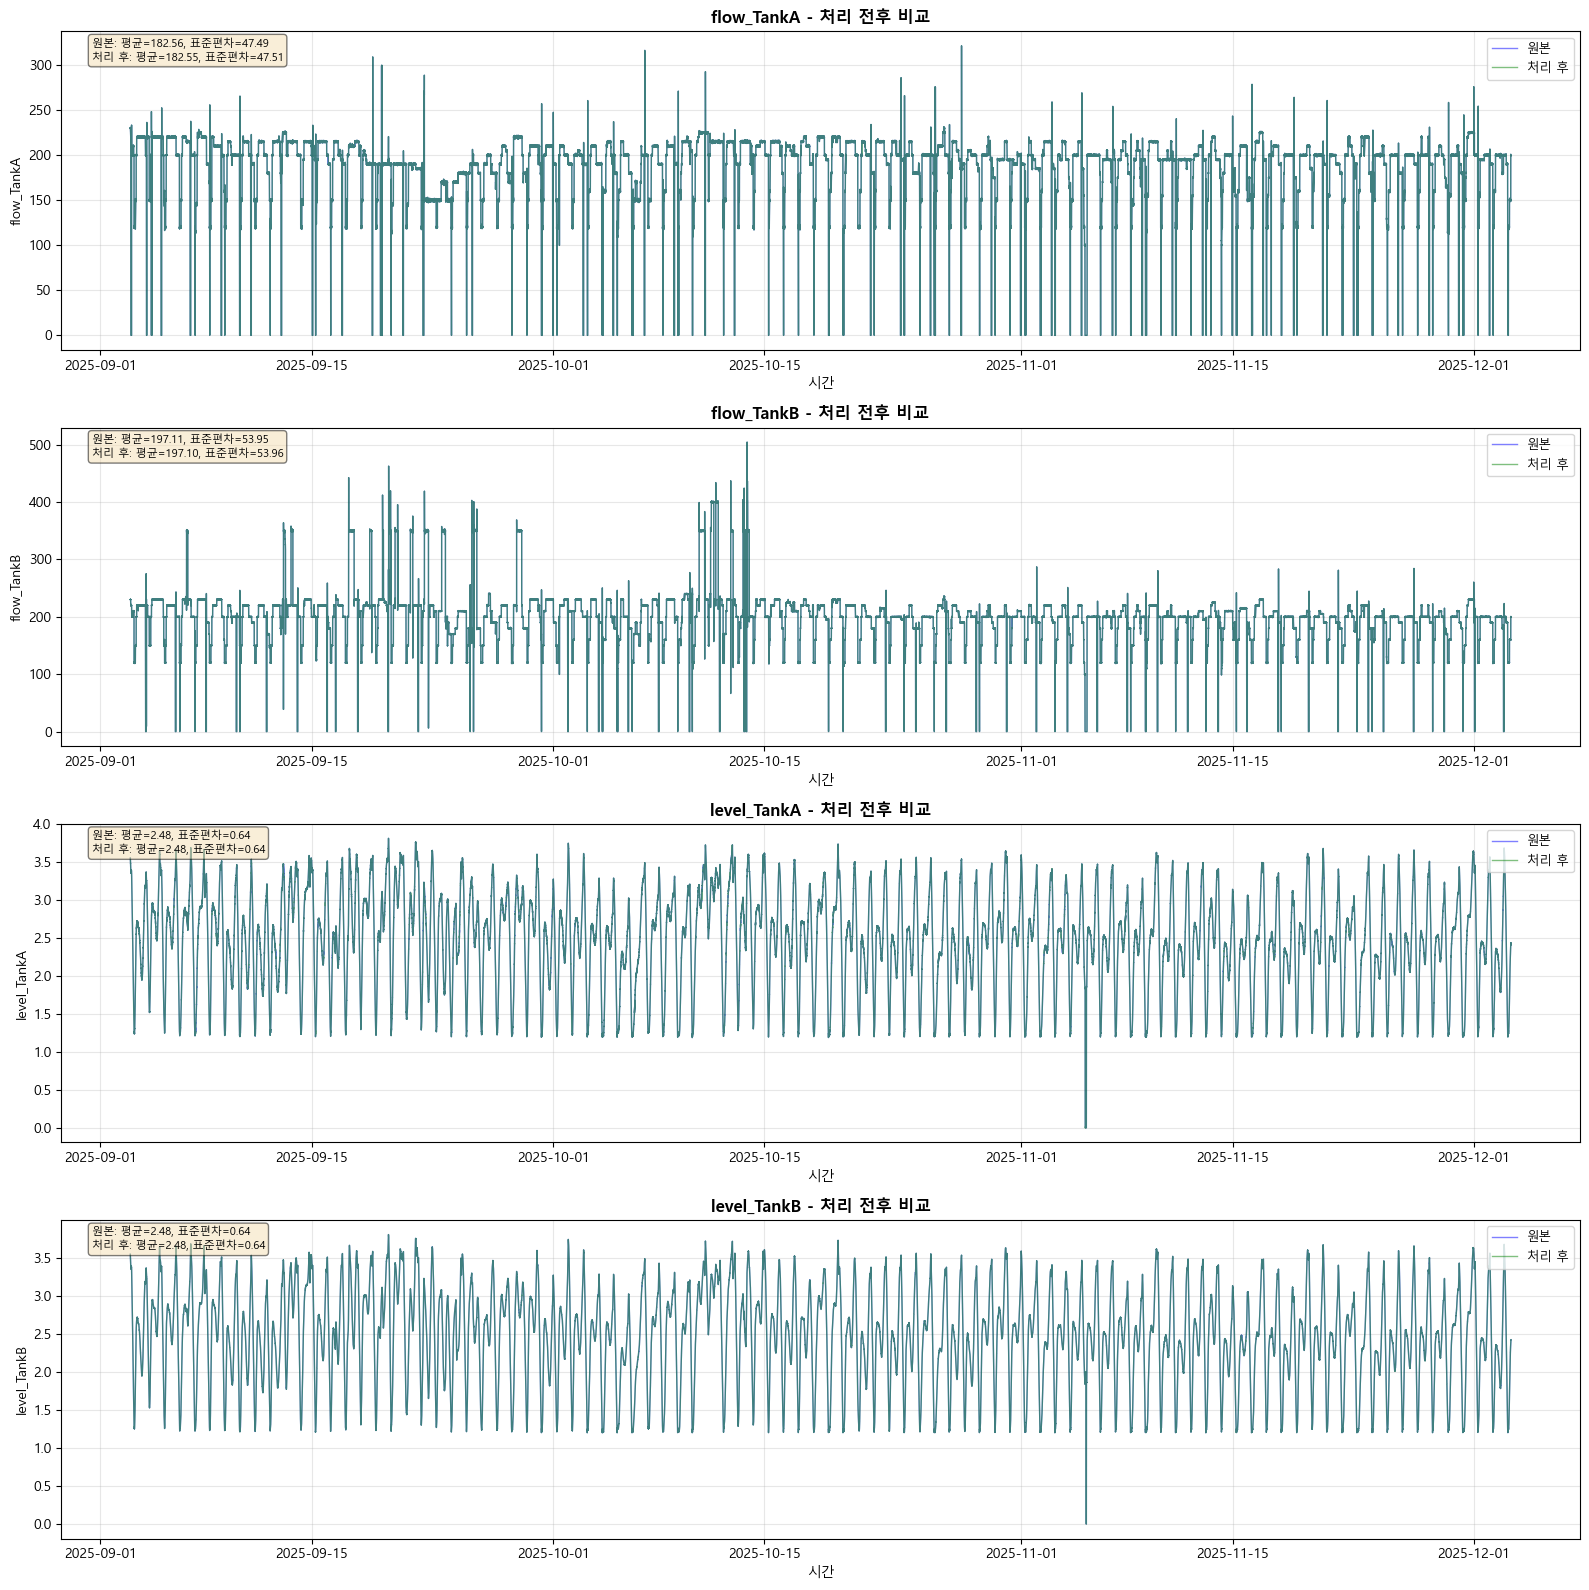

  요약 테이블 저장: ../../results/FLOW_summary.csv

################################################################################
# [AWS368] 데이터 처리 시작
################################################################################

시간 간격 체크: 1분 간격으로 reindex 완료
  원본 행 수: 781875, 처리 후 행 수: 781921

[TA] 처리 중...
  결측치(리인덱스 후): 10940개
  대체 후 결측치: 0개 | ffill=9703, ema=1237, rollmed=0

[RN_15m] 처리 중...
  결측치(리인덱스 후): 12682개
  대체 후 결측치: 0개 | ffill=9718, ema=2964, rollmed=0

[RN_60m] 처리 중...
  결측치(리인덱스 후): 12943개
  대체 후 결측치: 0개 | ffill=9711, ema=3232, rollmed=0

[RN_12H] 처리 중...
  결측치(리인덱스 후): 17909개
  대체 후 결측치: 0개 | ffill=9543, ema=8366, rollmed=0

[RN_DAY] 처리 중...
  결측치(리인덱스 후): 12597개
  대체 후 결측치: 0개 | ffill=9711, ema=2886, rollmed=0

[HM] 처리 중...
  결측치(리인덱스 후): 10940개
  대체 후 결측치: 0개 | ffill=9703, ema=1237, rollmed=0

[TD] 처리 중...
  결측치(리인덱스 후): 10940개
  대체 후 결측치: 0개 | ffill=9703, ema=1237, rollmed=0

[AWS368] 처리 요약
    컬럼  원본_결측 원본_결측률(%)  처리후_결측 원본_평균 처리후_평균 원본_표준편차 처리후_표준편차
    TA  10894     

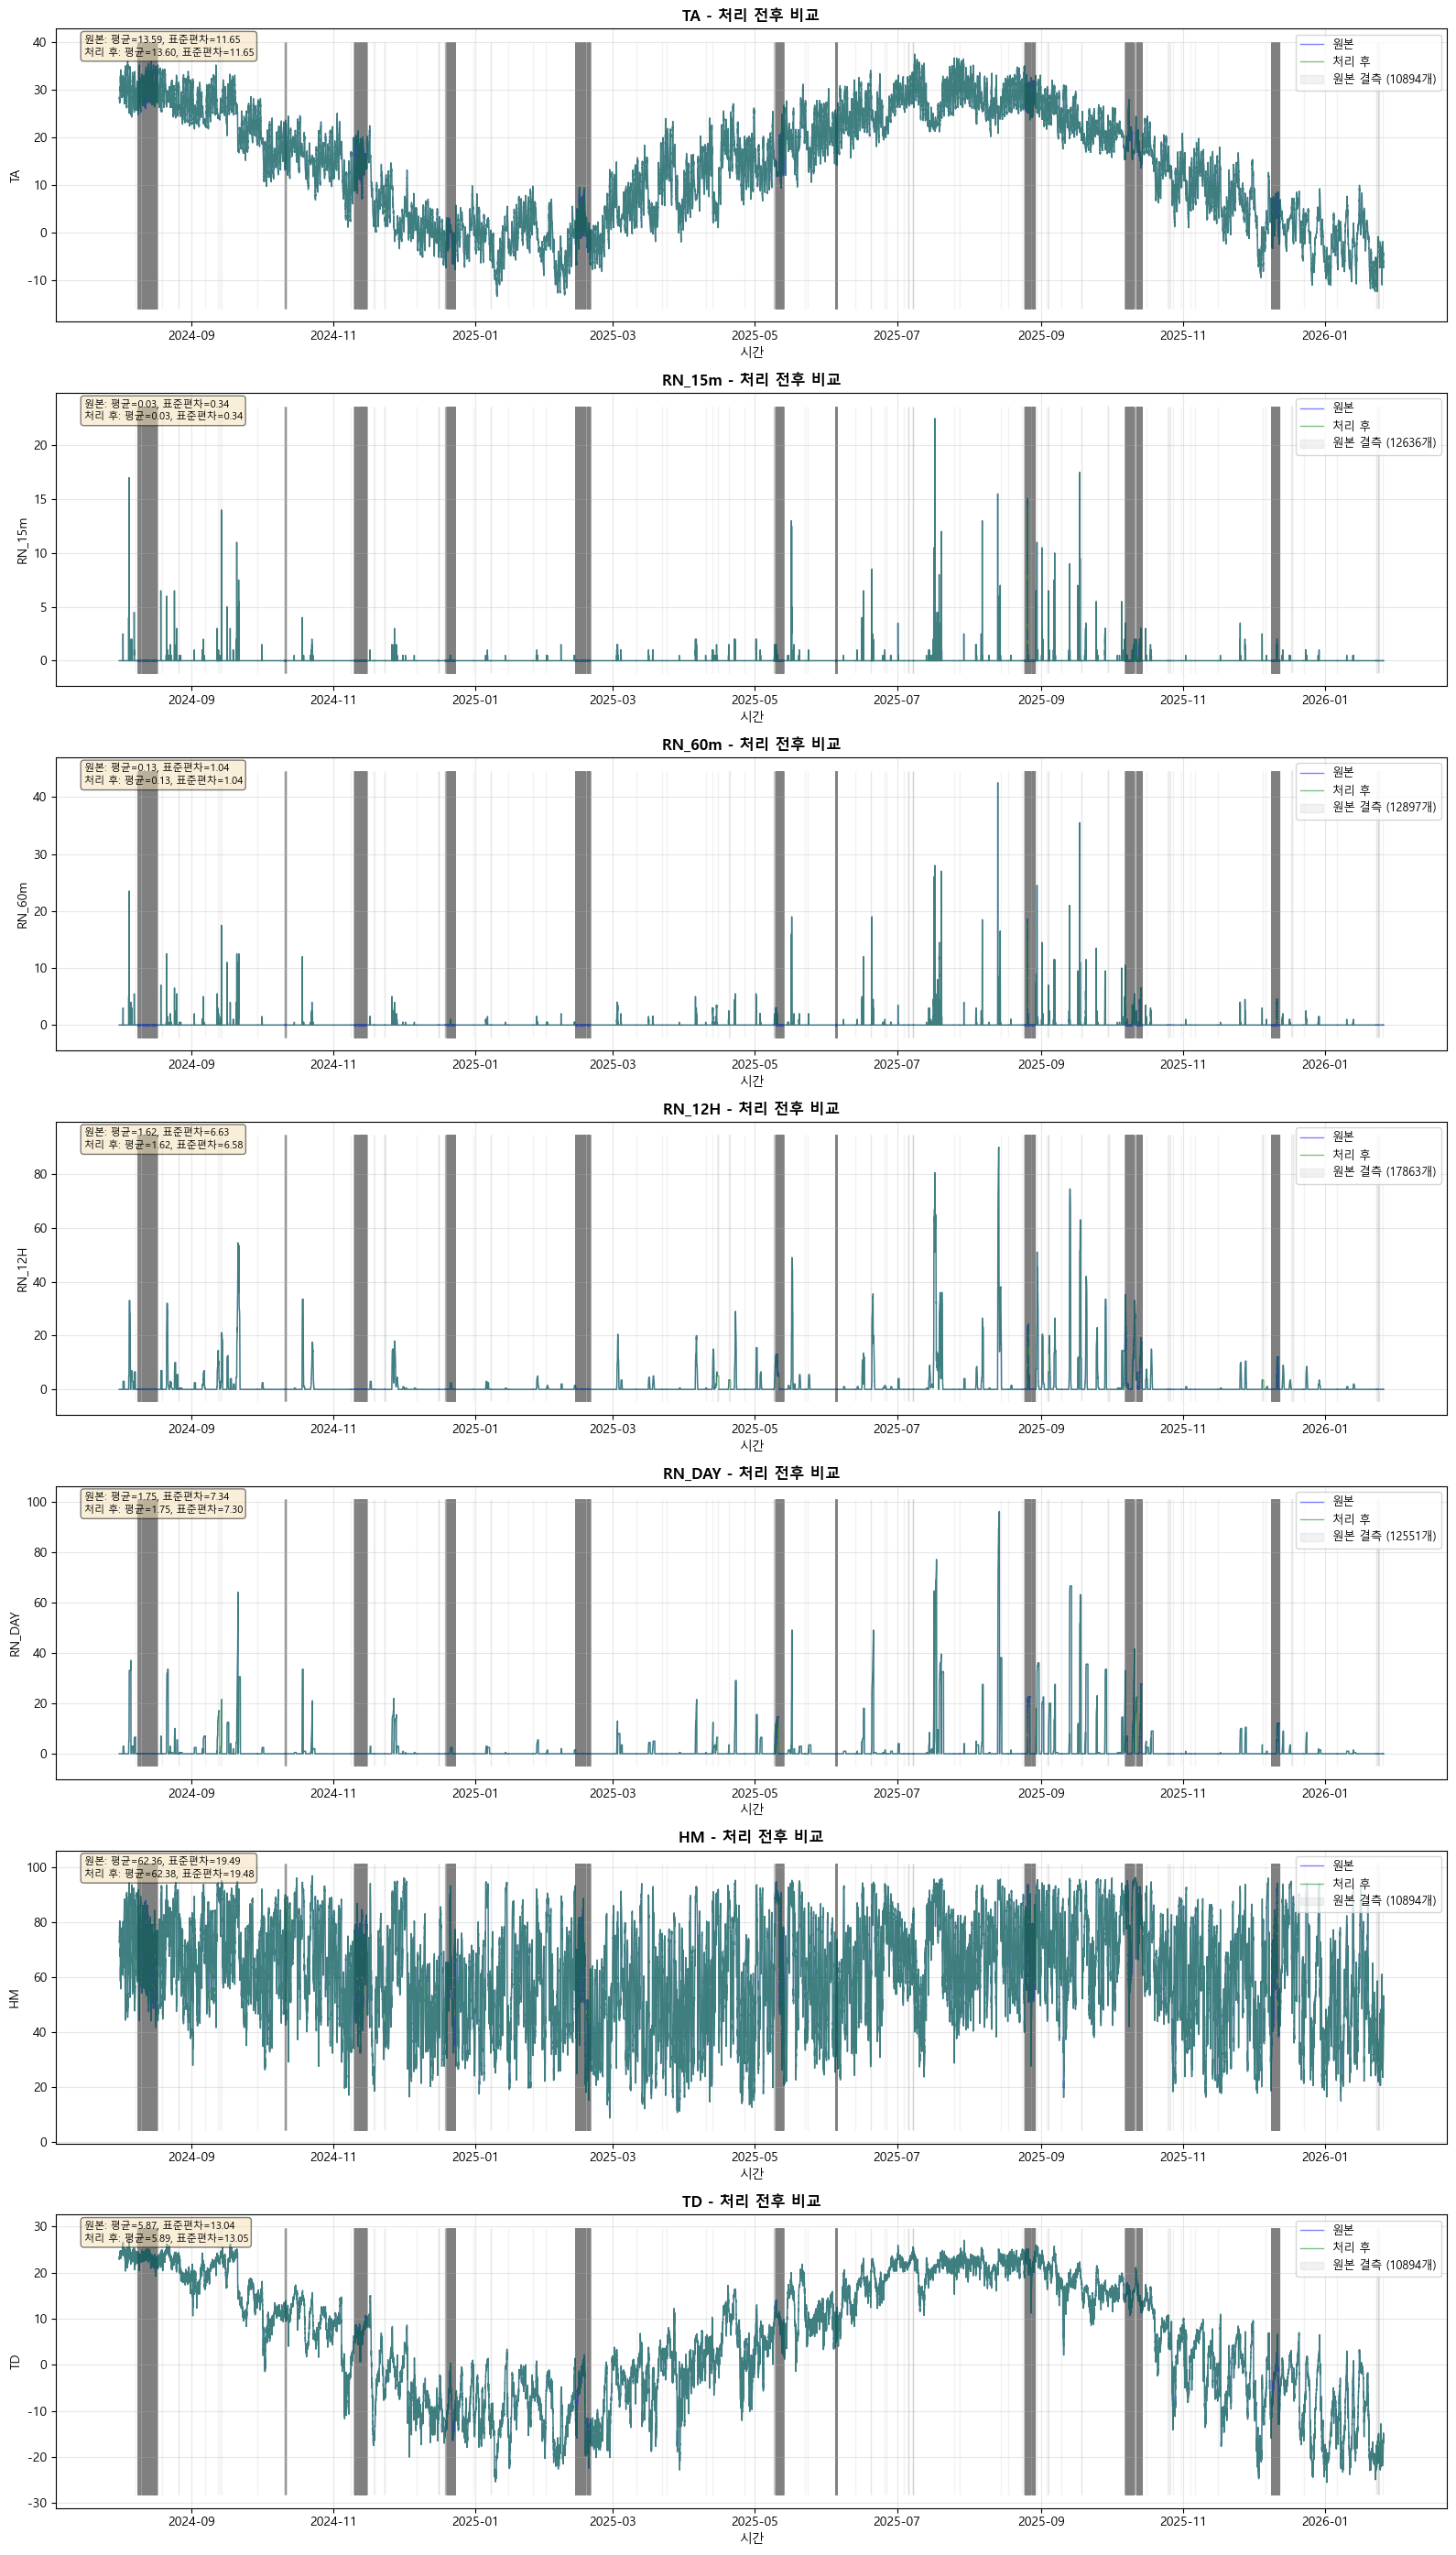

  요약 테이블 저장: ../../results/AWS368_summary.csv

################################################################################
# [AWS541] 데이터 처리 시작
################################################################################

시간 간격 체크: 이미 1분 간격
  원본 행 수: 830880, 처리 후 행 수: 830880

[TA] 처리 중...
  결측치(리인덱스 후): 61634개
  대체 후 결측치: 0개 | ffill=288, ema=61346, rollmed=0

[RN_15m] 처리 중...
  결측치(리인덱스 후): 67564개
  대체 후 결측치: 0개 | ffill=409, ema=67155, rollmed=0

[RN_60m] 처리 중...
  결측치(리인덱스 후): 67953개
  대체 후 결측치: 0개 | ffill=352, ema=67601, rollmed=0

[RN_12H] 처리 중...
  결측치(리인덱스 후): 74259개
  대체 후 결측치: 0개 | ffill=412, ema=73847, rollmed=0

[RN_DAY] 처리 중...
  결측치(리인덱스 후): 67290개
  대체 후 결측치: 0개 | ffill=320, ema=66970, rollmed=0

[HM] 처리 중...
  결측치(리인덱스 후): 60775개
  대체 후 결측치: 0개 | ffill=273, ema=60502, rollmed=0

[TD] 처리 중...
  결측치(리인덱스 후): 61634개
  대체 후 결측치: 0개 | ffill=288, ema=61346, rollmed=0

[AWS541] 처리 요약
    컬럼  원본_결측 원본_결측률(%)  처리후_결측 원본_평균 처리후_평균 원본_표준편차 처리후_표준편차
    TA  61634      7.42   

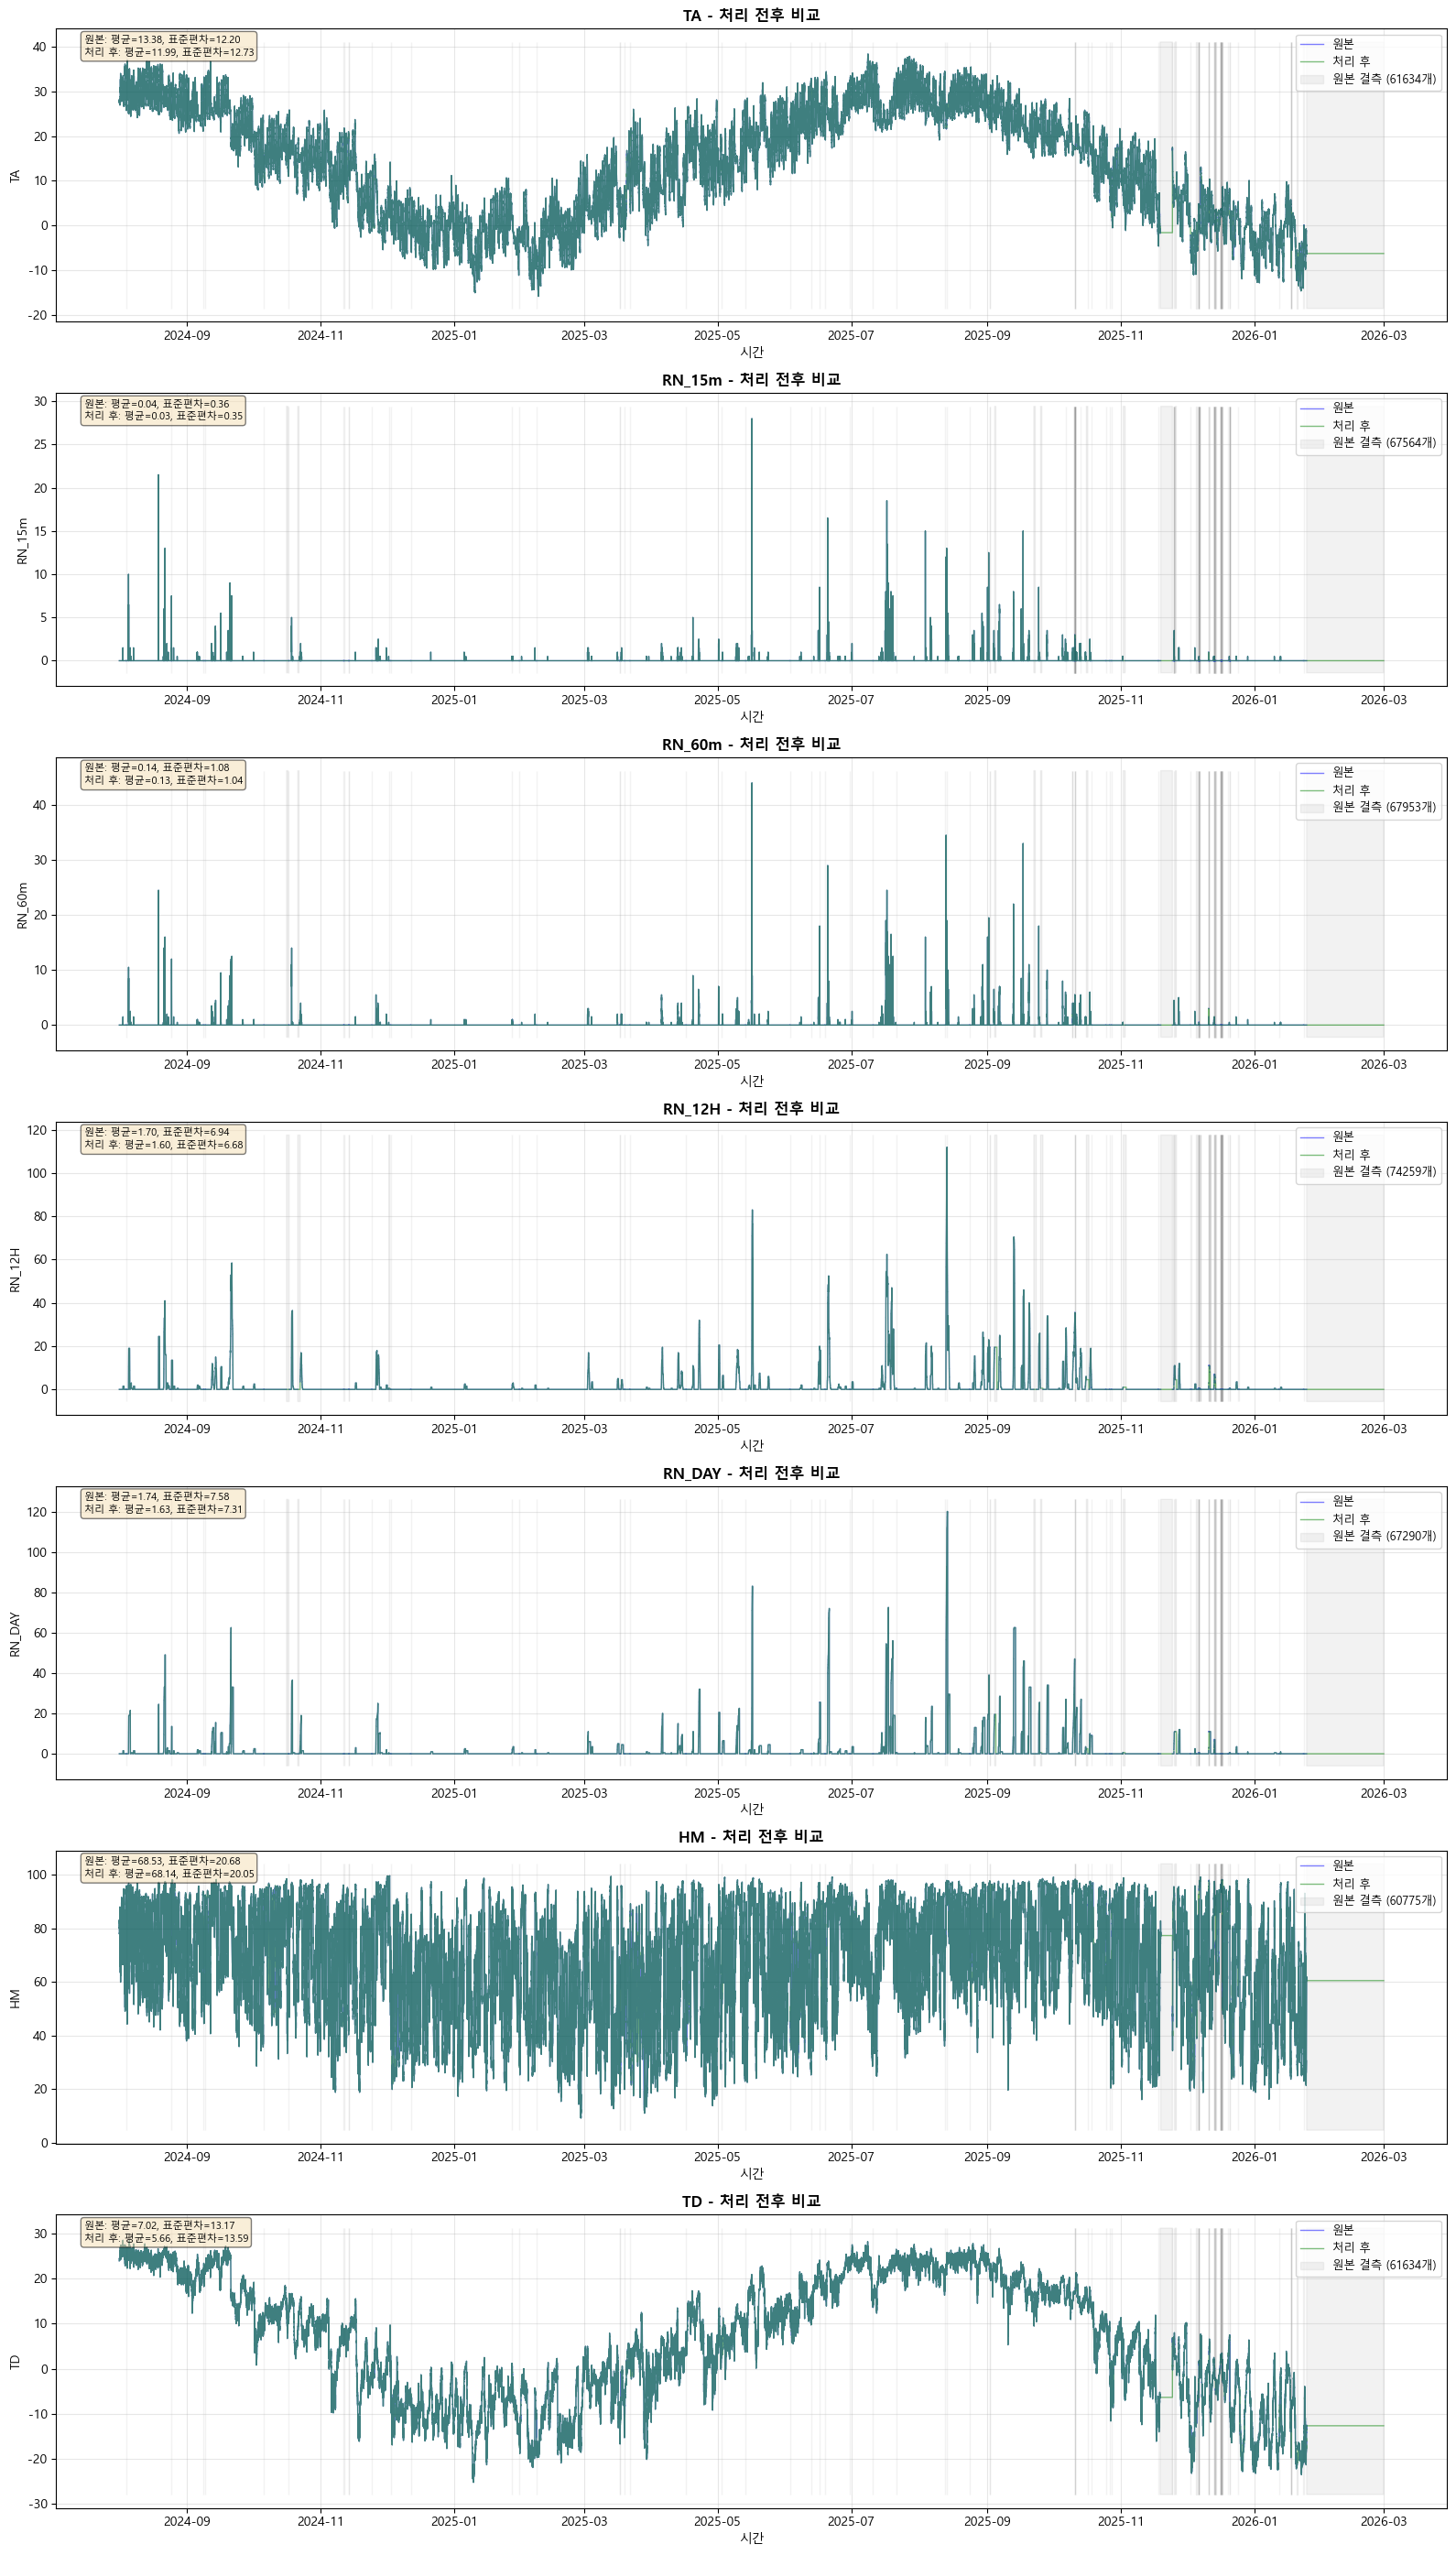

  요약 테이블 저장: ../../results/AWS541_summary.csv

################################################################################
# [AWS569] 데이터 처리 시작
################################################################################

시간 간격 체크: 이미 1분 간격
  원본 행 수: 780790, 처리 후 행 수: 780790

[TA] 처리 중...
  결측치(리인덱스 후): 92개
  대체 후 결측치: 0개 | ffill=40, ema=52, rollmed=0

[RN_15m] 처리 중...
  결측치(리인덱스 후): 5633개
  대체 후 결측치: 0개 | ffill=92, ema=5541, rollmed=0

[RN_60m] 처리 중...
  결측치(리인덱스 후): 6034개
  대체 후 결측치: 0개 | ffill=103, ema=5931, rollmed=0

[RN_12H] 처리 중...
  결측치(리인덱스 후): 10795개
  대체 후 결측치: 0개 | ffill=101, ema=10694, rollmed=0

[RN_DAY] 처리 중...
  결측치(리인덱스 후): 5517개
  대체 후 결측치: 0개 | ffill=84, ema=5433, rollmed=0

[HM] 처리 중...
  결측치(리인덱스 후): 88개
  대체 후 결측치: 0개 | ffill=36, ema=52, rollmed=0

[TD] 처리 중...
  결측치(리인덱스 후): 92개
  대체 후 결측치: 0개 | ffill=40, ema=52, rollmed=0

[AWS569] 처리 요약
    컬럼  원본_결측 원본_결측률(%)  처리후_결측 원본_평균 처리후_평균 원본_표준편차 처리후_표준편차
    TA     92      0.01       0 13.35  13.35   11.65   

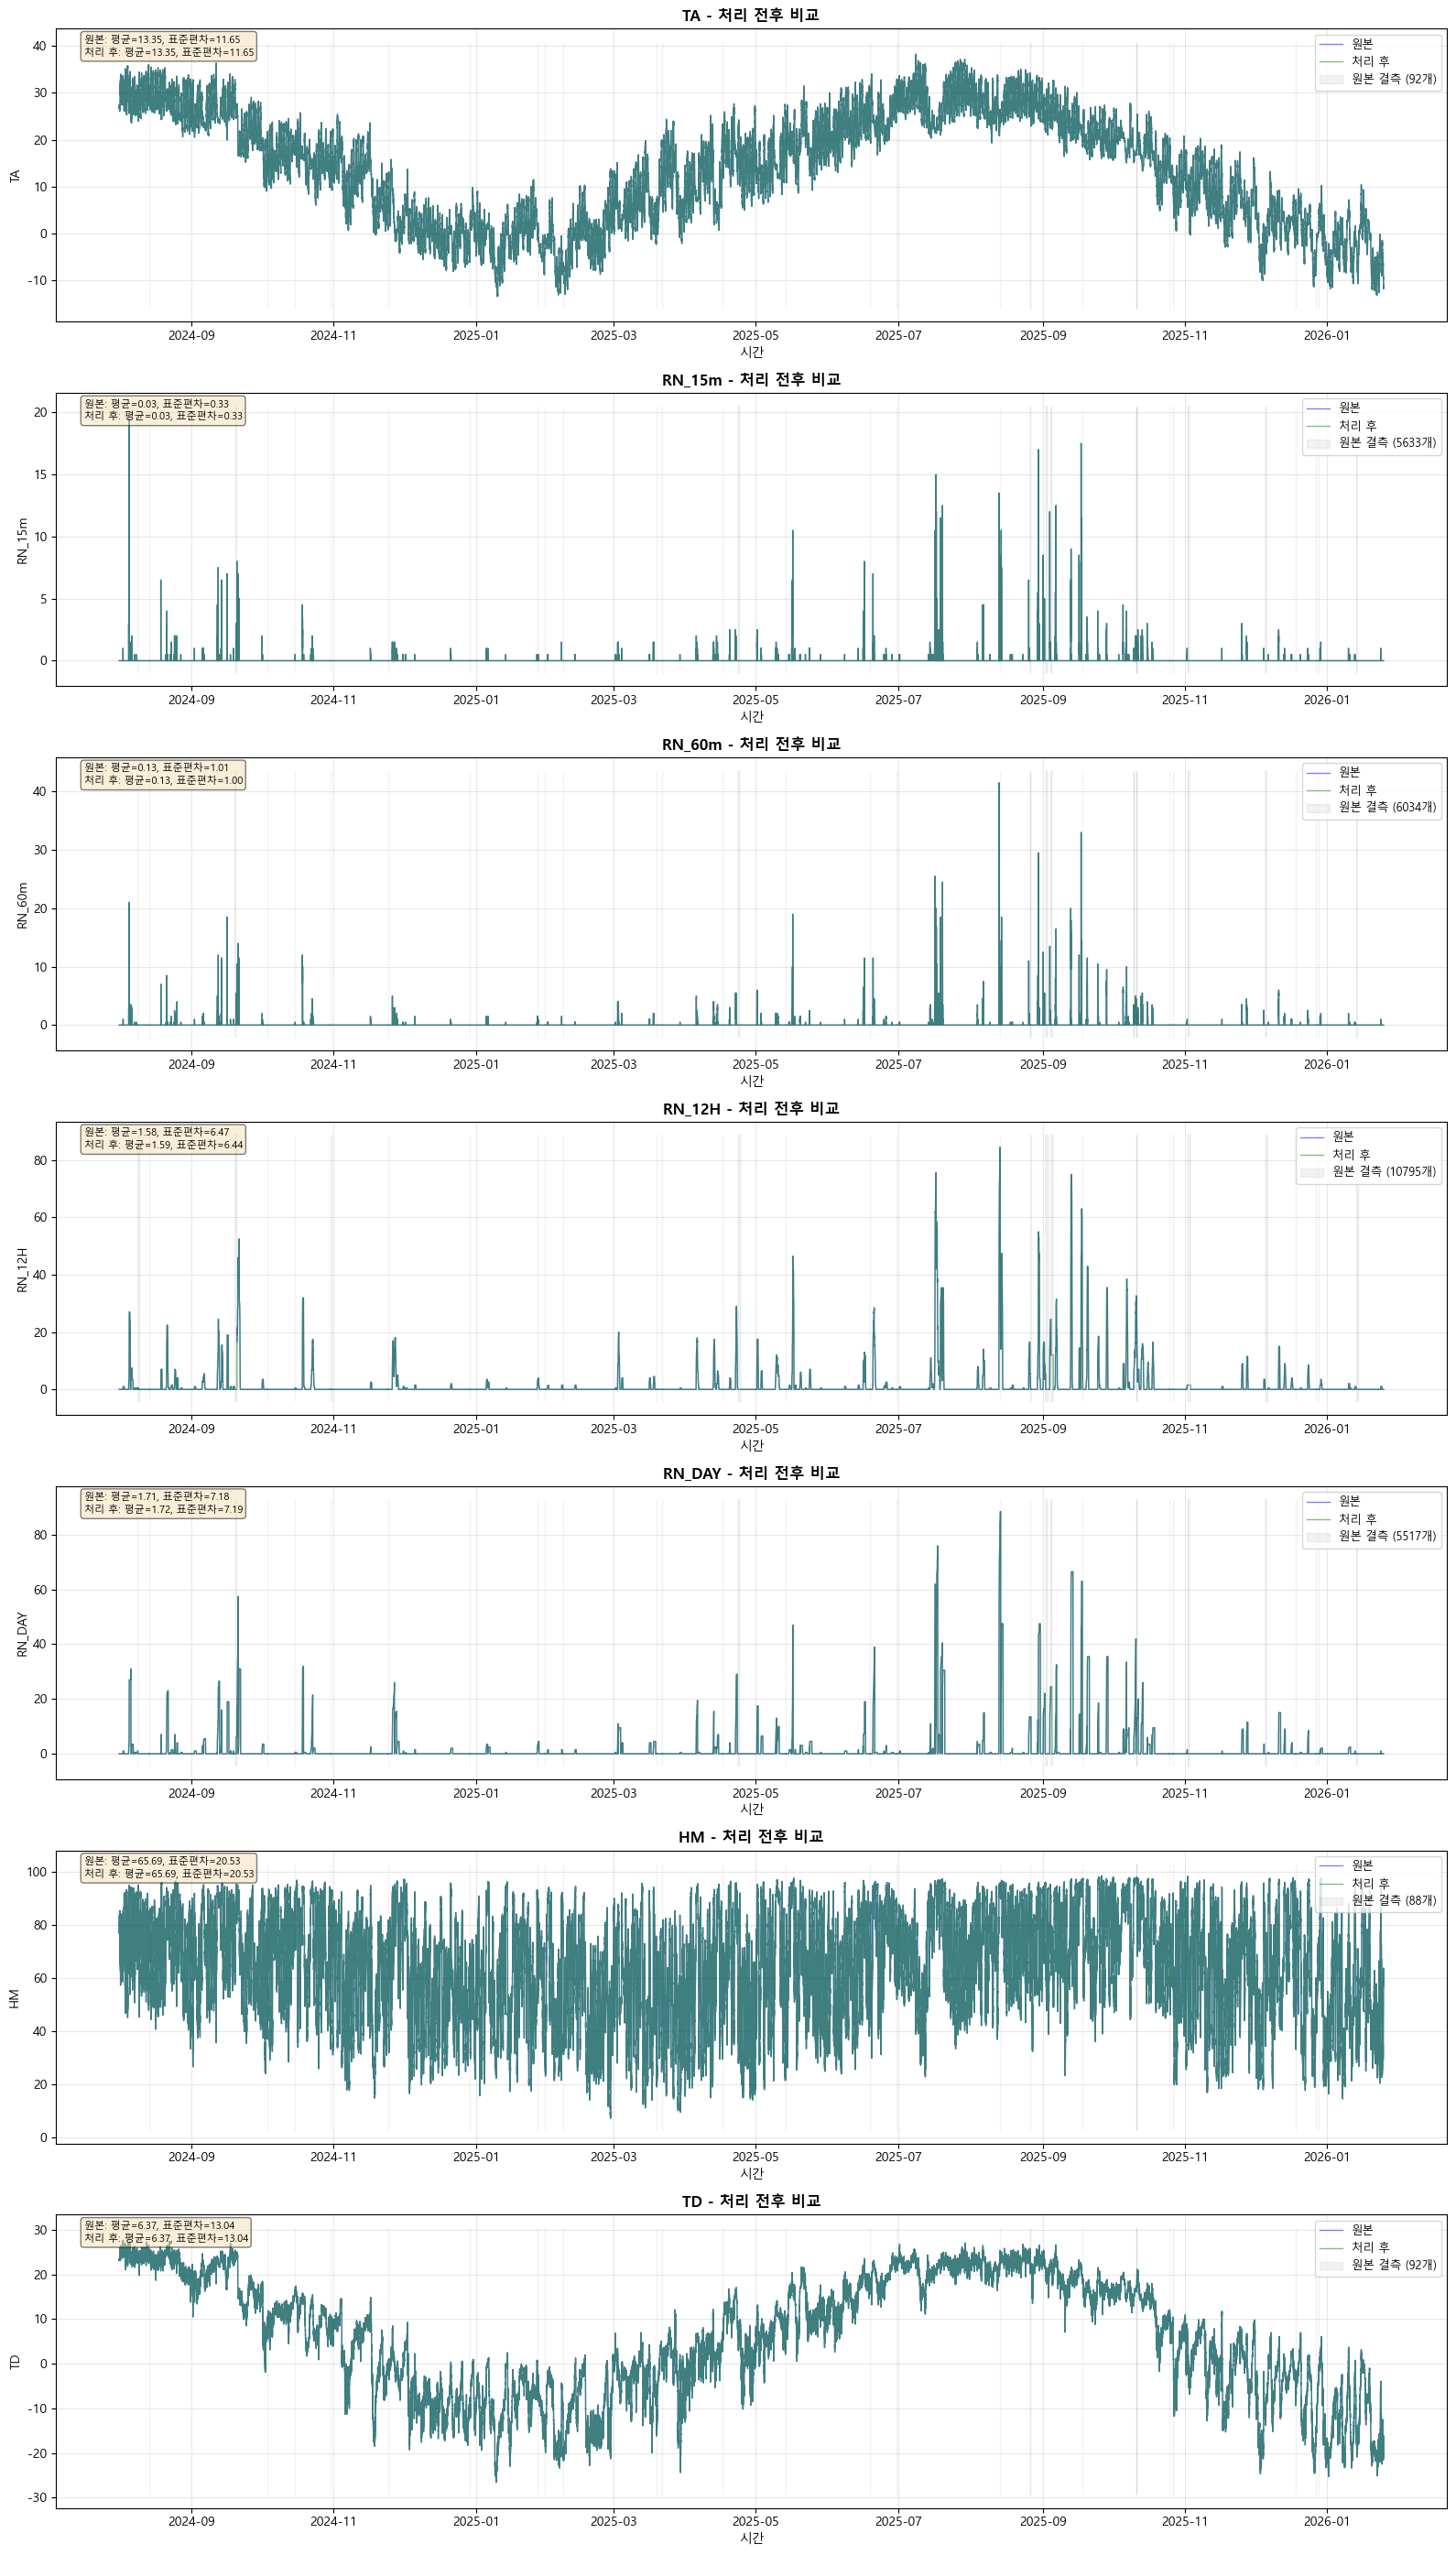

  요약 테이블 저장: ../../results/AWS569_summary.csv


In [17]:
tms_processed = process_dataframe(tms, tms_columns, 'TMS', time_col="SYS_TIME",
                                 ffill_limit_steps=6, ema_span_steps=12, rolling_median_window_steps=288)
flow_processed = process_dataframe(flow, flow_columns, 'FLOW', time_col="SYS_TIME",
                                  ffill_limit_steps=6, ema_span_steps=12, rolling_median_window_steps=288)
aws368_processed = process_dataframe(aws368, aws_columns, 'AWS368', time_col="datetime",
                                    ffill_limit_steps=6, ema_span_steps=12, rolling_median_window_steps=288)
aws541_processed = process_dataframe(aws541, aws_columns, 'AWS541', time_col="datetime",
                                    ffill_limit_steps=6, ema_span_steps=12, rolling_median_window_steps=288)
aws569_processed = process_dataframe(aws569, aws_columns, 'AWS569', time_col="datetime",
                                    ffill_limit_steps=6, ema_span_steps=12, rolling_median_window_steps=288)

In [18]:
tms_processed.to_csv('../../data/processed/TMS_cleaned_mask.csv', index=False, encoding='utf-8-sig')
print("  TMS 저장: data/processed/TMS_cleaned.csv")

flow_processed.to_csv('../../data/processed/FLOW_cleaned_mask.csv', index=False, encoding='utf-8-sig')
print("  FLOW 저장: data/processed/FLOW_cleaned.csv")

aws368_processed.to_csv('../../data/processed/AWS368_cleaned_mask.csv', index=False, encoding='utf-8-sig')
print("  AWS 저장: data/processed/AWS368_cleaned.csv")

aws541_processed.to_csv('../../data/processed/AWS541_cleaned_mask.csv', index=False, encoding='utf-8-sig')
print("  AWS 저장: data/processed/AWS541_cleaned.csv")

aws569_processed.to_csv('../../data/processed/AWS569_cleaned_mask.csv', index=False, encoding='utf-8-sig')
print("  AWS 저장: data/processed/AWS569_cleaned.csv")

  TMS 저장: data/processed/TMS_cleaned.csv
  FLOW 저장: data/processed/FLOW_cleaned.csv
  AWS 저장: data/processed/AWS368_cleaned.csv
  AWS 저장: data/processed/AWS541_cleaned.csv
  AWS 저장: data/processed/AWS569_cleaned.csv


In [19]:
def check_time_interval(df, time_col='time', expected_interval_minutes=1):
    """
    시계열 데이터의 시간 간격을 확인
    
    Parameters:
    -----------
    df : DataFrame
        확인할 데이터프레임
    time_col : str
        시간 컬럼명
    expected_interval_minutes : int
        예상 간격 (분)
    
    Returns:
    --------
    dict : 분석 결과
    """
    # 시간 컬럼을 datetime으로 변환
    df[time_col] = pd.to_datetime(df[time_col])
    
    # 시간 차이 계산 (분 단위)
    time_diffs = df[time_col].diff().dt.total_seconds() / 60
    
    # 첫 번째 값은 NaN이므로 제거
    time_diffs = time_diffs.dropna()
    
    # 통계 계산
    result = {
        '총_데이터_수': len(df),
        '평균_간격(분)': time_diffs.mean(),
        '중앙값_간격(분)': time_diffs.median(),
        '최소_간격(분)': time_diffs.min(),
        '최대_간격(분)': time_diffs.max(),
        '표준편차(분)': time_diffs.std(),
        '예상_간격(분)': expected_interval_minutes,
        '예상_간격_일치_비율(%)': (time_diffs == expected_interval_minutes).sum() / len(time_diffs) * 100
    }
    
    # 간격별 빈도 계산
    interval_counts = time_diffs.value_counts().sort_index()
    
    # 결과 출력
    print(f"\n{'='*80}")
    print(f"시간 간격 분석 결과")
    print(f"{'='*80}")
    print(f"총 데이터 수: {result['총_데이터_수']:,}개")
    print(f"평균 간격: {result['평균_간격(분)']:.2f}분")
    print(f"중앙값 간격: {result['중앙값_간격(분)']:.2f}분")
    print(f"최소 간격: {result['최소_간격(분)']:.2f}분")
    print(f"최대 간격: {result['최대_간격(분)']:.2f}분")
    print(f"표준편차: {result['표준편차(분)']:.2f}분")
    print(f"\n{expected_interval_minutes}분 간격 일치율: {result['예상_간격_일치_비율(%)']:.2f}%")
    
    print(f"\n{'='*80}")
    print(f"간격별 빈도 (상위 10개)")
    print(f"{'='*80}")
    print(interval_counts.head(10))
    
    # 비정상 간격 찾기 (예상 간격이 아닌 경우)
    abnormal_intervals = time_diffs[time_diffs != expected_interval_minutes]
    
    if len(abnormal_intervals) > 0:
        print(f"\n{'='*80}")
        print(f"비정상 간격 발견: {len(abnormal_intervals)}개 ({len(abnormal_intervals)/len(time_diffs)*100:.2f}%)")
        print(f"{'='*80}")
        
        # 비정상 간격의 위치 찾기
        abnormal_indices = abnormal_intervals.index
        abnormal_details = []
        
        for idx in abnormal_indices[:10]:  # 처음 10개만 출력
            prev_idx = df.index[df.index.get_loc(idx) - 1]
            abnormal_details.append({
                '이전_시간': df.loc[prev_idx, time_col],
                '현재_시간': df.loc[idx, time_col],
                '간격(분)': time_diffs.loc[idx]
            })
        
        abnormal_df = pd.DataFrame(abnormal_details)
        print("\n비정상 간격 예시 (처음 10개):")
        print(abnormal_df.to_string(index=False))
    else:
        print(f"\n모든 데이터가 {expected_interval_minutes}분 간격으로 일치합니다!")
    
    return result, interval_counts, abnormal_intervals

In [20]:
def check_missing_timestamps(df, time_col='time', expected_interval_minutes=1):
    """
    누락된 타임스탬프 확인
    
    Parameters:
    -----------
    df : DataFrame
        확인할 데이터프레임
    time_col : str
        시간 컬럼명
    expected_interval_minutes : int
        예상 간격 (분)
    """
    # 시간 컬럼을 datetime으로 변환
    df[time_col] = pd.to_datetime(df[time_col])
    
    # 예상되는 전체 시간 범위 생성
    start_time = df[time_col].min()
    end_time = df[time_col].max()
    expected_range = pd.date_range(start=start_time, end=end_time, 
                                   freq=f'{expected_interval_minutes}min')
    
    # 실제 데이터와 비교
    actual_times = set(df[time_col])
    expected_times = set(expected_range)
    
    missing_times = expected_times - actual_times
    
    print(f"\n{'='*80}")
    print(f"누락된 타임스탬프 분석")
    print(f"{'='*80}")
    print(f"예상 데이터 수: {len(expected_range):,}개")
    print(f"실제 데이터 수: {len(df):,}개")
    print(f"누락된 데이터 수: {len(missing_times):,}개")
    print(f"누락 비율: {len(missing_times)/len(expected_range)*100:.2f}%")
    
    if len(missing_times) > 0:
        missing_sorted = sorted(list(missing_times))[:20]  # 처음 20개만
        print(f"\n누락된 타임스탬프 예시 (처음 20개):")
        for ts in missing_sorted:
            print(f"  {ts}")
    
    return missing_times

In [21]:
tms = pd.read_csv("../../data/processed/TMS_cleaned_mask.csv")
flow = pd.read_csv("../../data/processed/FLOW_cleaned_mask.csv")
aws368 = pd.read_csv("../../data/processed/AWS368_cleaned_mask.csv")
aws541 = pd.read_csv("../../data/processed/AWS541_cleaned_mask.csv")
aws569 = pd.read_csv("../../data/processed/AWS569_cleaned_mask.csv")

In [22]:
# 컬럼명 변경
aws368 = aws368.add_suffix('_368')
aws541 = aws541.add_suffix('_541')
aws569 = aws569.add_suffix('_569')

# join
aws = aws541.join([aws368, aws569], how='left')

In [23]:
aws = aws.set_index('datetime_368')

In [24]:
aws["SYS_TIME"] = aws["datetime_541"]

C:\Users\user\AppData\Local\Temp\ipykernel_11184\337278054.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  aws["SYS_TIME"] = aws["datetime_541"]


In [25]:
aws = aws.drop(columns=['datetime_541', 'datetime_569'])

In [27]:
aws.to_csv('../../data/processed/AWS_cleaned_mask.csv', index=False, encoding='utf-8-sig')

In [30]:
# TMS 데이터 확인
print("\n" + "="*80)
print("TMS 데이터 시간 간격 확인")
print("="*80)
tms_result, tms_intervals, tms_abnormal = check_time_interval(tms, time_col='SYS_TIME', expected_interval_minutes=1)
tms_missing = check_missing_timestamps(tms, time_col='SYS_TIME', expected_interval_minutes=1)

# FLOW 데이터 확인
print("\n" + "="*80)
print("FLOW 데이터 시간 간격 확인")
print("="*80)
flow_result, flow_intervals, flow_abnormal = check_time_interval(flow, time_col='SYS_TIME', expected_interval_minutes=1)
flow_missing = check_missing_timestamps(flow, time_col='SYS_TIME', expected_interval_minutes=1)

# AWS 데이터 확인
print("\n" + "="*80)
print("AWS 데이터 시간 간격 확인")
print("="*80)
aws_result, aws_intervals, aws_abnormal = check_time_interval(aws, time_col='SYS_TIME', expected_interval_minutes=1)
aws_missing = check_missing_timestamps(aws, time_col='SYS_TIME', expected_interval_minutes=1)


TMS 데이터 시간 간격 확인

시간 간격 분석 결과
총 데이터 수: 573,975개
평균 간격: 1.00분
중앙값 간격: 1.00분
최소 간격: 1.00분
최대 간격: 1.00분
표준편차: 0.00분

1분 간격 일치율: 100.00%

간격별 빈도 (상위 10개)
SYS_TIME
1.0    573974
Name: count, dtype: int64

모든 데이터가 1분 간격으로 일치합니다!

누락된 타임스탬프 분석
예상 데이터 수: 573,975개
실제 데이터 수: 573,975개
누락된 데이터 수: 0개
누락 비율: 0.00%

FLOW 데이터 시간 간격 확인

시간 간격 분석 결과
총 데이터 수: 131,687개
평균 간격: 1.00분
중앙값 간격: 1.00분
최소 간격: 1.00분
최대 간격: 1.00분
표준편차: 0.00분

1분 간격 일치율: 100.00%

간격별 빈도 (상위 10개)
SYS_TIME
1.0    131686
Name: count, dtype: int64

모든 데이터가 1분 간격으로 일치합니다!

누락된 타임스탬프 분석
예상 데이터 수: 131,687개
실제 데이터 수: 131,687개
누락된 데이터 수: 0개
누락 비율: 0.00%

AWS 데이터 시간 간격 확인

시간 간격 분석 결과
총 데이터 수: 830,880개
평균 간격: 1.00분
중앙값 간격: 1.00분
최소 간격: 1.00분
최대 간격: 1.00분
표준편차: 0.00분

1분 간격 일치율: 100.00%

간격별 빈도 (상위 10개)
SYS_TIME
1.0    830879
Name: count, dtype: int64

모든 데이터가 1분 간격으로 일치합니다!

누락된 타임스탬프 분석
예상 데이터 수: 830,880개
실제 데이터 수: 830,880개
누락된 데이터 수: 0개
누락 비율: 0.00%
